In [1]:
import numpy as np
from numpy import random
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import itertools
import os
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras.utils.np_utils import to_categorical
import pandas as pd
path='C:\\Users\dmckenzie\Desktop\K12RoomTypeClassData2.csv'
DATIS=pd.read_csv(path)
DATIS=DATIS.drop(columns='Unnamed: 0')
import re
def preprocessor(text): 
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text

DATIS['CleanName']=DATIS['RoomName'].str.replace('/',' ').replace({' +':' '},regex=True).apply(preprocessor)
DATIS['NameLen']=DATIS['RoomName'].str.len()
DATIS['RoomName']=DATIS['RoomName'].str.lower()
DATIS['TokenCount']=((DATIS['RoomName'].str.len()-DATIS['RoomName'].str.replace(' ','').str.len())+1)
DATIS.Label2=DATIS.Label2.str.lower()
DATIS['RoomType']=np.where(DATIS['RoomName'].str.lower().str.contains('corridor'),'corridor',
         np.where(DATIS['RoomName'].str.lower().str.contains('shower'),'shower',
         np.where(DATIS['RoomName'].str.contains('|'.join([' rr','restroom','bathroom','lavartory',
                                                        'washroom','wash room','wash_room',
                                                        'tlt','toielt','bath room','rest room',
                                                        'bath_room','rest_room'])),'bathroom',
           np.where(DATIS['Label2']=='small group','other',        
          np.where(DATIS['Label2']=='special english','other',DATIS['Label2'])))))

binomiallist=[]
for i in range(0,len(DATIS)):
        binomiallist.append(np.random.binomial(1, .025))

DATIS['Keep']=binomiallist
DATIS['Keep']=np.where(DATIS['RoomType']=='other',DATIS['Keep'],1)
DATIS2=DATIS[DATIS['Keep']==1]
DATIS2=DATIS2.drop_duplicates(['RoomType','CleanName'])
y = DATIS2.RoomType.str.lower()
DATIS2['Name'] = DATIS2['CleanName']
X = DATIS2['Name']
        

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)

In [3]:
len(y_train.drop_duplicates())

23

In [4]:
train_size = int(len(X_train))
train_posts = X_train
train_tags = y_train

test_posts = X_test
test_tags = y_test

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train2 = encoder.transform(train_tags)
y_test2 = encoder.transform(test_tags)

num_classes = 23
y_train2 = to_categorical(y_train2, num_classes)
y_test2 = to_categorical(y_test2, num_classes)

In [6]:
from tensorflow.keras import layers
adapt_data = list(X_train)
# Create a TextVectorization layer
text_vectorizer = layers.TextVectorization(output_mode="int")
# Index the vocabulary via `adapt()`
text_vectorizer.adapt(adapt_data)

# Try out the layer
#print("Encoded text:\n", text_vectorizer(["The Brain is deeper than the sea"]).numpy(),)

# Create a simple model
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(input_dim=text_vectorizer.vocabulary_size(), output_dim=16)(inputs)
x = layers.Dense(10,activation='relu')(x)
outputs = layers.Dense(1,'sigmoid')(x)
model = keras.Model(inputs, outputs)

# Create a labeled dataset (which includes unknown tokens)
#train_dataset = tf.data.Dataset.from_tensor_slices(
#    (list(X_train), list(np.where(y_train=='classroom',1,0)))
#)

# Preprocess the string inputs, turning them into int sequences
#train_dataset = train_dataset.batch(2).map(lambda x, y: (text_vectorizer(x), y))

vectorized=text_vectorizer(list(X_train))
# Train the model on the int sequences
print("\nTraining model...")
model.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])
model.fit(vectorized,np.array(list(np.where(y_train=='classroom',1,0))),epochs=1,validation_split=0.1)

# For inference, you can export a model that accepts strings as input
inputs = keras.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
outputs = model(x)
end_to_end_model = keras.Model(inputs, outputs)

# Call the end-to-end model on test data (which includes unknown tokens)
print("\nCalling end-to-end model on test string...")
test_data = tf.constant(["classroom e"])
test_output = end_to_end_model(test_data)
print("Model output:", test_output)


Training model...
20/20 [==============================] - 1s 17ms/step - loss: 0.6741 - accuracy: 0.7838 - val_loss: 0.6523 - val_accuracy: 0.8615

Calling end-to-end model on test string...
Model output: tf.Tensor(
[[[0.511724 ]
  [0.4728446]]], shape=(1, 2, 1), dtype=float32)


In [19]:
from tensorflow.keras import layers
adapt_data = list(X_train)
# Create a TextVectorization layer
text_vectorizer = layers.TextVectorization(output_mode="int")
# Index the vocabulary via `adapt()`
text_vectorizer.adapt(adapt_data)

# Try out the layer
#print("Encoded text:\n", text_vectorizer(["The Brain is deeper than the sea"]).numpy(),)

# Create a simple model
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(input_dim=text_vectorizer.vocabulary_size(), output_dim=16)(inputs)
x = layers.Dense(10,activation='relu')(x)
outputs = layers.Dense(23,'softmax')(x)
model = keras.Model(inputs, outputs)

# Create a labeled dataset (which includes unknown tokens)
#train_dataset = tf.data.Dataset.from_tensor_slices(
#    (list(X_train), list(np.where(y_train=='classroom',1,0)))
#)

# Preprocess the string inputs, turning them into int sequences
#train_dataset = train_dataset.batch(2).map(lambda x, y: (text_vectorizer(x), y))

vectorized=text_vectorizer(list(X_train))
# Train the model on the int sequences
print("\nTraining model...")
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy'])
model.fit(vectorized,y_train2,epochs=1,validation_split=0.1)

# For inference, you can export a model that accepts strings as input
inputs = keras.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
outputs = model(x)
end_to_end_model = keras.Model(inputs, outputs)

# Call the end-to-end model on test data (which includes unknown tokens)
print("\nCalling end-to-end model on test string...")
test_data = tf.constant(["classroom e"])
test_output = end_to_end_model(test_data)
print("Model output:", test_output)


Training model...


ValueError: in user code:

    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:789 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\losses.py:1666 categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 23) and (None, 6, 23) are incompatible


In [12]:
from tensorflow.keras import layers
adapt_data = list(X_train)
# Create a TextVectorization layer
text_vectorizer = layers.TextVectorization(output_mode="int")
# Index the vocabulary via `adapt()`
text_vectorizer.adapt(adapt_data)

# Try out the layer
#print("Encoded text:\n", text_vectorizer(["The Brain is deeper than the sea"]).numpy(),)

# Create a simple model
model = Sequential()
model.add(layers.Embedding(,output_dim=10))
model.add(layers.Dense(10))
model.add(layers.Dense(23))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(vectorized,
                    y_train2,
                    batch_size=10,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)



TypeError: __init__() missing 1 required positional argument: 'output_dim'

In [20]:
batch_size = 10
epochs = 2

# Build the model
model = Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(text_vectorizer)
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(23))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(X_train, y_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

ValueError: The last dimension of the inputs to `Dense` should be defined. Found `None`.

In [64]:
del model
batch_size = 500
epochs = 500

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/500
2/2 [==============================] - 0s 105ms/step - loss: 3.1311 - accuracy: 0.0467 - val_loss: 3.0550 - val_accuracy: 0.3333
Epoch 2/500
2/2 [==============================] - 0s 25ms/step - loss: 3.0343 - accuracy: 0.2040 - val_loss: 2.9485 - val_accuracy: 0.3472
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 2.9275 - accuracy: 0.2227 - val_loss: 2.7935 - val_accuracy: 0.3611
Epoch 4/500
2/2 [==============================] - 0s 24ms/step - loss: 2.7874 - accuracy: 0.2461 - val_loss: 2.5941 - val_accuracy: 0.4167
Epoch 5/500
2/2 [==============================] - 0s 23ms/step - loss: 2.6210 - accuracy: 0.2539 - val_loss: 2.3987 - val_accuracy: 0.4444
Epoch 6/500
2/2 [==============================] - 0s 24ms/step - loss: 2.4832 - accuracy: 0.2913 - val_loss: 2.2592 - val_accuracy: 0.4306
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 2.3873 - accuracy: 0.2835 - val_loss: 2.1408 - val_accuracy: 0.4444
Epoch 8/500
2/2 [==

2/2 [==============================] - 0s 24ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.1283 - val_accuracy: 0.9722
Epoch 118/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.1298 - val_accuracy: 0.9722
Epoch 119/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.1303 - val_accuracy: 0.9722
Epoch 120/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1307 - val_accuracy: 0.9722
Epoch 121/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.1296 - val_accuracy: 0.9722
Epoch 122/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1246 - val_accuracy: 0.9722
Epoch 123/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.1185 - val_accuracy: 0.9722
Epoch 124/500
2/2 [=

Epoch 175/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1112 - val_accuracy: 0.9722
Epoch 176/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1049 - val_accuracy: 0.9722
Epoch 177/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1016 - val_accuracy: 0.9722
Epoch 178/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.1042 - val_accuracy: 0.9722
Epoch 179/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1081 - val_accuracy: 0.9722
Epoch 180/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1111 - val_accuracy: 0.9722
Epoch 181/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1137 - val_accuracy: 0.9722
Epoch 

Epoch 289/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1261 - val_accuracy: 0.9583
Epoch 290/500
2/2 [==============================] - 0s 23ms/step - loss: 5.6466e-04 - accuracy: 1.0000 - val_loss: 0.1298 - val_accuracy: 0.9583
Epoch 291/500
2/2 [==============================] - 0s 23ms/step - loss: 4.4167e-04 - accuracy: 1.0000 - val_loss: 0.1333 - val_accuracy: 0.9722
Epoch 292/500
2/2 [==============================] - 0s 22ms/step - loss: 5.3445e-04 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 0.9722
Epoch 293/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1385 - val_accuracy: 0.9722
Epoch 294/500
2/2 [==============================] - 0s 25ms/step - loss: 7.3997e-04 - accuracy: 1.0000 - val_loss: 0.1399 - val_accuracy: 0.9722
Epoch 295/500
2/2 [==============================] - 0s 25ms/step - loss: 3.6518e-04 - accuracy: 1.0000 - val_loss: 0.1413 - val_acc

2/2 [==============================] - 0s 27ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.1572 - val_accuracy: 0.9583
Epoch 402/500
2/2 [==============================] - 0s 25ms/step - loss: 5.5606e-04 - accuracy: 1.0000 - val_loss: 0.1646 - val_accuracy: 0.9583
Epoch 403/500
2/2 [==============================] - 0s 25ms/step - loss: 2.1873e-04 - accuracy: 1.0000 - val_loss: 0.1710 - val_accuracy: 0.9722
Epoch 404/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1759 - val_accuracy: 0.9722
Epoch 405/500
2/2 [==============================] - 0s 24ms/step - loss: 2.2782e-04 - accuracy: 1.0000 - val_loss: 0.1798 - val_accuracy: 0.9722
Epoch 406/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0020 - accuracy: 0.9984 - val_loss: 0.1869 - val_accuracy: 0.9722
Epoch 407/500
2/2 [==============================] - 0s 25ms/step - loss: 4.1729e-04 - accuracy: 1.0000 - val_loss: 0.1922 - val_accuracy: 0.9722
Epoc

In [56]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 18ms/step - loss: 0.5811 - accuracy: 0.9097
Test accuracy: 0.9096638560295105


In [57]:
classes = np.argmax(model.predict(x_test), axis = 1)
print(classes)


[10  3  3 21 10 10 12 22 10  2 22 10 18 11 17 13 22  2 10 18 18 22  3  3
  3 13 22 18  8  3 10 15 10 10  3  4  2  3  1  3  3 22  3 18  3  9 22 13
  3 17  4 10  2 10  2 10 13 22 22 10 10  3  3 22 20  5 18 22 11 13  2 19
 18 10 13 10 22 20 18  3 10  2 17 17 22  3 22  8 13  2  3  3  4 17  3  3
 17 20  3 13 15  3  5  3  3 18 22  2  1 10 22 10  3 17 18 18 10  3  1  2
  3  3  9 11 18  2  3  4 10  9 22  3  2  4 22 17 22 18 10 12 18 16  3 18
  2 20 18  2 17 10  3 10  8 21 18 14 14 20 20  9 22 15  3  0 10 13  3 20
  0  6 17  9 20 13 17 20 20 12 18 13 21 22 15  3  5 17  8 18 16 10 14  2
  2 10 22 17 18  3  6 22 13  3  3 15 17 16 17 14  4 13 15  5  3 17 18 22
 15 12 16 15  7 18  6  3  3 22  3 13  3 10 22 19 13 12 22 13 13 22 15  3
  2 13  4 10  3  3 14  1 10 13  0 18 10 22 18 20  3 10 10  2  3  4  3 18
 17 13  3  1 15  3  2  2 17  3 22 22 10 18 22 12  5  4  3  4 18 16  2 10
 18 17  3  2  3  3  3 18 13 22 19 13 16  3 17 17  2  3 10 10 18 18 10 18
  2  7 18 18 20  4  3  8  3 17  6  3  3 20  3 10  3

<AxesSubplot:>

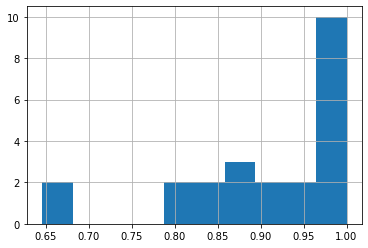

In [58]:
pd.DataFrame({'Guess':classes,
              'Win':(classes==np.argmax(y_test,axis=1))*1}).assign(dummy=1).groupby('Guess').agg('sum').reset_index().\
    assign(WinRate=lambda x : x.Win/x.dummy)['WinRate'].hist()

In [59]:
pd.DataFrame({'Guess':classes,
              'Win':(classes==np.argmax(y_test,axis=1))*1}).assign(dummy=1).groupby('Guess').agg('sum').reset_index().\
    assign(WinRate=lambda x : x.Win/x.dummy)['WinRate'].median()

0.9411764705882353

In [153]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
import tensorflow as tf
import string
import re


In [171]:
max_features

20000

In [172]:
del inputs

In [173]:
del model

NameError: name 'model' is not defined

In [174]:
del x

NameError: name 'x' is not defined

In [175]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)


In [176]:
vectorize_layer.adapt(np.array(X_train))

In [170]:
max_features

20000

In [177]:


inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(inputs)
x = layers.Embedding(max_features+1, embedding_dim)(x)

x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(23, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [178]:
epochs = 3

# Fit the model using the train and test datasets.
model.fit(np.array(X_train),np.array(y_train), epochs=epochs)

Epoch 1/3


ValueError: in user code:

    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:789 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\losses.py:1666 categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\dmckenzie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 23) are incompatible


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [31]:

#finding

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


parameters = {
    #'tfidf__ngram_range': ((1, 1), (1, 2),(1, 3),(1,4)), 
    'tfidf__max_df': (0.25,.4 ,0.5,.6,0.75, 1.0),
    'tfidf__use_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    'tfidf__smooth_idf' : (True, False),
    'tfidf__min_df' : (1, 2,3),
    'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001,0.0001,0.001,0.01)
    #'clf__loss': ('log', 'perceptron'),
    #'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
    #'clf__penalty': ('l2', 'elasticnet','l1')
}


pipeline = Pipeline([
               ('tfidf', TfidfVectorizer()),
               ('clf', SGDClassifier(loss='log',penalty='l1')),
              ])

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = grid_search.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


accuracy 0.9173669467787114
                   precision    recall  f1-score   support

             a.v.       0.80      0.42      0.55        19
        art exist       0.91      1.00      0.95        10
         bathroom       1.00      0.90      0.95        70
        classroom       0.94      0.97      0.95       125
 conference large       1.00      1.00      1.00        12
         corridor       0.88      1.00      0.93        14
        custodial       0.83      0.71      0.77         7
       electrical       0.86      1.00      0.92         6
              gym       0.90      1.00      0.95        18
 kitchen district       1.00      1.00      1.00         4
              lab       1.00      0.93      0.96        88
      library sto       1.00      1.00      1.00         6
       lobby vest       0.91      1.00      0.95        10
    locker shower       0.85      1.00      0.92        39
lounge leadership       1.00      0.88      0.93         8
       mechanical       1.0

In [32]:
grid_search.best_params_

{'tfidf__max_df': 0.4,
 'tfidf__min_df': 1,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True}

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


tfidfvec=TfidfVectorizer(ngram_range=(1,3),max_df=.25,min_df=1,norm='l2',smooth_idf=True,sublinear_tf=False,use_idf=True)
mod=SGDClassifier(penalty='l1',loss='log',alpha=0.00001)

#vectorizer.fit(X_train)
#X_train2=vectorizer.transform(X_train)
#X_test2=vectorizer.transform(X_test)




text_clf = Pipeline([ 
    ('tfidf', tfidfvec),
    ('clf', mod),
])


text_clf.fit(X_train, y_train)

#mod.fit(X_train2, y_train)

from sklearn.metrics import classification_report
#y_pred = mod.predict(X_test2)
y_pred2 = text_clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred2, y_test))
print(classification_report(y_test, y_pred2))


#print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred))

accuracy 0.9103641456582633
                   precision    recall  f1-score   support

             a.v.       0.83      0.53      0.65        19
        art exist       0.91      1.00      0.95        10
         bathroom       0.97      0.90      0.93        70
        classroom       0.94      0.96      0.95       125
 conference large       0.92      1.00      0.96        12
         corridor       0.88      1.00      0.93        14
        custodial       1.00      0.86      0.92         7
       electrical       0.86      1.00      0.92         6
              gym       0.90      1.00      0.95        18
 kitchen district       0.80      1.00      0.89         4
              lab       0.93      0.93      0.93        88
      library sto       0.86      1.00      0.92         6
       lobby vest       0.91      1.00      0.95        10
    locker shower       0.85      1.00      0.92        39
lounge leadership       1.00      1.00      1.00         8
       mechanical       0.9

In [34]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType
from onnxmltools import save_model
from onnxruntime import InferenceSession

In [35]:
onnx_model = convert_sklearn(text_clf,
name='RoomTypeClassifier',
initial_types=[('input', StringTensorType([1, 1]))]
)

save_model(onnx_model, 'RoomClass.onnx')
sess = InferenceSession("RoomClass.onnx")
label_name = sess.get_outputs()[0].name
input_name = sess.get_inputs()[0].name

#res = sess.run(None, input_feed={'input': np.array([['corridor']])})

C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\skl2onnx\operator_converters\text_vectoriser.py:185: UserWarning: Converter for TfidfVectorizer will use scikit-learn regular expression by default in version 1.6.
  UserWarning)
C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\skl2onnx\common\_container.py:595: UserWarning: Unable to find operator 'Tokenizer' in domain 'com.microsoft' in ONNX, op_version is forced to 1.
  op_type, domain))


NameError: name 'sess' is not defined

In [115]:
res

[array(['corridor'], dtype=object),
 [{'a.v.': 0.0005470490432344377,
   'art exist': 9.61030600592494e-05,
   'bathroom': 0.00018557437579147518,
   'classroom': 0.0002550547069404274,
   'conference large': 0.0008631146629340947,
   'corridor': 0.9907276630401611,
   'custodial': 0.0006747011211700737,
   'electrical': 0.00015836229431442916,
   'gym': 0.0010776950512081385,
   'kitchen district': 0.0007900006021372974,
   'lab': 0.0002391795424045995,
   'library sto': 0.00027800322277471423,
   'lobby vest': 0.0005601845914497972,
   'locker shower': 0.0007997159264050424,
   'lounge leadership': 0.0004221965791657567,
   'mechanical': 0.0003763679414987564,
   'music vocal': 9.92583081824705e-05,
   'office specialist': 0.0002946862077806145,
   'other': 3.795786824412062e-06,
   'principal vice': 0.00038096358184702694,
   'science': 2.462184420437552e-05,
   'shower': 0.000591575400903821,
   'storage': 0.0005541396676562726}]]

In [43]:
with open("TextClassifier1.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [42]:
res

[array(['services1'], dtype=object),
 [{'amenity': 0.07348394393920898,
   'circulation': 0.044751111418008804,
   'collaboration: closed': 0.07773763686418533,
   'collaboration: open': 0.04349435120820999,
   'desking: open workstation': 0.031024377793073654,
   'desking: private office': 0.049801651388406754,
   'lab': 0.04049787297844887,
   'services 2': 0.039142508059740067,
   'services1': 0.4987942576408386,
   'support': 0.10127229988574982}]]

In [336]:
import pickle

In [337]:
pickle.dump(vectorizer, open('C:\\Users\dmckenzie\documents\\roomvectorizer.pickle', "wb"))

In [338]:
pickle.dump(mod, open('C:\\Users\dmckenzie\documents\\roommodel.pickle', "wb"))

In [68]:
len(y_pred)
len(X_test)

4948

In [79]:
matchdf=pd.DataFrame({'A':list(y_pred2[X_test.isin(list(X_train))==False]),
              'B':list(y_test[X_test.isin(list(X_train))==False])})

In [80]:
matchdf['C']=(matchdf['A']==matchdf['B'])*1

In [81]:
matchdf['D']=1

In [82]:
labels=list(matchdf.groupby(['A'])['D'].sum().index)

In [83]:
scores=list(matchdf.groupby(['A'])['C'].sum().values/matchdf.groupby(['A'])['D'].sum().values)

In [84]:
print('Accuracy:',matchdf['C'].sum()/matchdf['D'].sum())

Accuracy: 0.8950617283950617


In [85]:
pd.DataFrame({'Category':labels,'Guesses':list(matchdf.groupby(['A'])['D'].sum().values),'True Positive Rate':scores})

,Category,Guesses,True Positive Rate
0,art digital exist,10,0.600000
1,bathroom,32,0.843750
2,classroom,83,0.879518
3,collaboration student work,4,1.000000
4,common social collaboration,11,0.636364
5,conference resource collaboration,6,0.833333
6,corridor mail central,3,0.666667
7,lab exist flex,23,0.782609
8,locker athletic official,13,1.000000
9,mechanical yard auditorium,5,0.800000


C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 728, in fit
    sample_weight=sample_weight)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 541, in _fit
    accept_large_sparse=False)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\dmckenzie\Anaconda3\e

C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 728, in fit
    sample_weight=sample_weight)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 541, in _fit
    accept_large_sparse=False)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\dmckenzie\Anaconda3\e

<AxesSubplot:title={'center':'Classifier Validation Score As Training Data Grows'}, xlabel='Training Data Size', ylabel='Validation Score'>

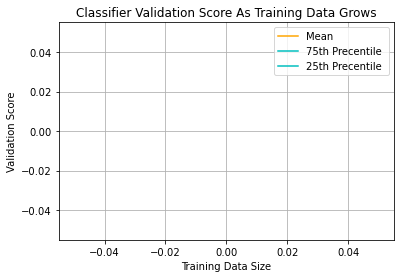

In [39]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

#np.random.seed(0)
#X, y = load_iris(return_X_y=True)
#indices = np.arange(y.shape[0])
#np.random.shuffle(indices)
#X, y = X[indices], y[indices]

train_sizes, train_scores, valid_scores = learning_curve(SGDClassifier(penalty='l1',loss='log',alpha=0.00001),
                                                         X_train, y_train, train_sizes=[10,20,30,40,50,60,70,80,90,100,
                                                                                         110,120,130,140,150,160,170,180,190,200,
                                                                                         210,220,230,240,250,260,270,280,290,300,
                                                                                         310,320,330,340,350,360,370,380,390,400,
                                                                                        410,420,430],cv=5)
pd.DataFrame({'Mean':list(pd.DataFrame(valid_scores.transpose()).median()),
             '75th Precentile ':list(pd.DataFrame(valid_scores.transpose()).quantile(0.75)),
             '25th Precentile':list(pd.DataFrame(valid_scores.transpose()).quantile(0.25))},
             index=train_sizes).plot(color = ['orange', 'c','c'],
                                    xlabel='Training Data Size',ylabel='Validation Score',
                                     grid=True,title='Classifier Validation Score As Training Data Grows')

In [37]:
pd.DataFrame(valid_scores.transpose()).mean().plot()

NameError: name 'valid_scores' is not defined

In [38]:
pd.DataFrame(pd.DataFrame(valid_scores.transpose())).plot()

NameError: name 'valid_scores' is not defined